In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import pickle

Load Preprocessed Data

In [6]:
data_dir = Path("../data/processed")
models_dir = Path("../models")
figures_dir = Path("../data/figures")
models_dir.mkdir(exist_ok=True)
figures_dir.mkdir(exist_ok=True)

# Load Station 1 data
data1 = np.load(data_dir / 'station1_processed_for_modeling.npz')
X_train1, y_train1, X_test1, y_test1 = data1['X_train'], data1['y_train'], data1['X_test'], data1['y_test']

# Load Station 2 data
data2 = np.load(data_dir / 'station2_processed_for_modeling.npz')
X_train2, y_train2, X_test2, y_test2 = data2['X_train'], data2['y_train'], data2['X_test'], data2['y_test']

# Store data in a dictionary for easy access
station_data = {
    'station1': {'X_train': X_train1, 'y_train': y_train1, 'X_test': X_test1, 'y_test': y_test1},
    'station2': {'X_train': X_train2, 'y_train': y_train2, 'X_test': X_test2, 'y_test': y_test2}
}

# Get input shape from the data (it's the same for all models)
# (timesteps, features) -> (24, 6)
input_shape = (X_train1.shape[1], X_train1.shape[2]) 
print(f"Input shape for models: {input_shape}")

Input shape for models: (24, 6)


Define Model Architectures

In [7]:
# A) LSTM Model
def build_lstm_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1) # Output layer predicts a single value (the error)
    ])
    return model

# B) SimpleRNN Model
def build_rnn_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        # Use SimpleRNN instead of GRU
        layers.SimpleRNN(64, return_sequences=True), 
        layers.Dropout(0.2),
        layers.SimpleRNN(32),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1) # Output layer predicts a single value (the error)
    ])
    return model

# C) Transformer Model
# The Transformer uses self-attention, which requires a custom layer implementation.
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_transformer_model(input_shape, head_size=128, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[64], dropout=0.1):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
    
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

# Store model-building functions in a dictionary
model_builders = {
    'lstm': build_lstm_model,
    'rnn': build_rnn_model,
    'transformer': build_transformer_model
}

Execute Training Loop


///// Training models for station1 /////

[DEBUG] NaNs in X_train: 0, y_train: 0
[DEBUG] X_train shape: (235244, 24, 6), y_train shape: (235244,)

--- Building and training LSTM model ---
[DEBUG] Model output shape: (None, 1)
INFO: Model will be saved to: C:\Users\John Waugh\Desktop\CS Projects\RunoffForecasting-2.0\models\station1_lstm_model.keras
Epoch 1/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - loss: 0.0022 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 2/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 0.0011 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 3/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 0.0010 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 4/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 0.0010 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 5/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 0.0010 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 6/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - 

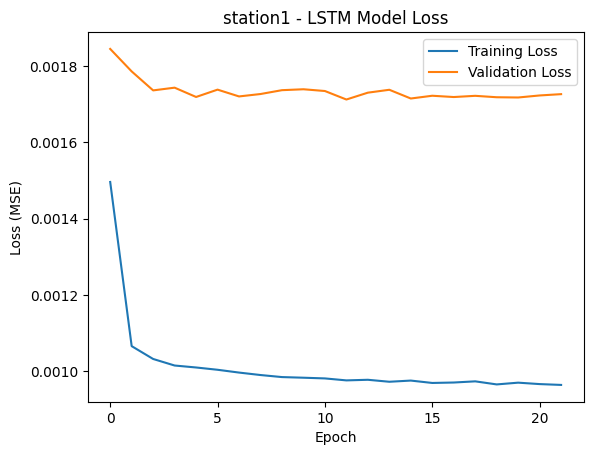


--- Building and training RNN model ---
[DEBUG] Model output shape: (None, 1)
INFO: Model will be saved to: C:\Users\John Waugh\Desktop\CS Projects\RunoffForecasting-2.0\models\station1_rnn_model.keras
Epoch 1/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0312 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 2/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0030 - val_loss: 0.0030 - learning_rate: 1.0000e-04
Epoch 3/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0019 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 4/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0015 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 5/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0013 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 6/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0012 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 7/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0012 - val_loss: 0.0020 - lear

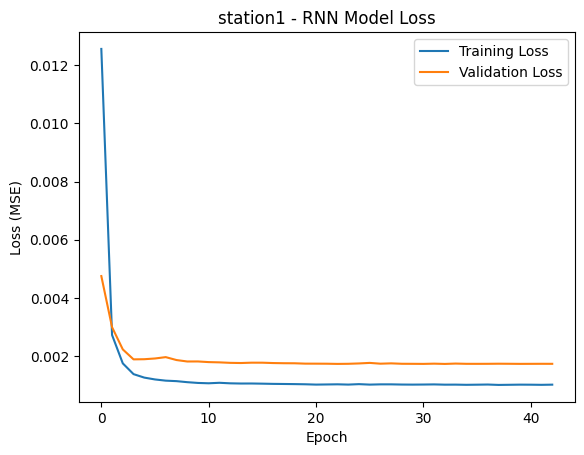


--- Building and training TRANSFORMER model ---
[DEBUG] Model output shape: (None, 1)
INFO: Model will be saved to: C:\Users\John Waugh\Desktop\CS Projects\RunoffForecasting-2.0\models\station1_transformer_model.keras
Epoch 1/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 320s 211ms/step - loss: 0.0136 - val_loss: 0.0025 - learning_rate: 1.0000e-04
Epoch 2/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 320s 218ms/step - loss: 0.0019 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 3/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 310s 211ms/step - loss: 0.0015 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 4/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 320s 217ms/step - loss: 0.0013 - val_loss: 0.0026 - learning_rate: 1.0000e-04
Epoch 5/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 317s 215ms/step - loss: 0.0012 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 6/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 317s 215ms/step - loss: 0.0011 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 7/50
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 324s 220ms/step - l

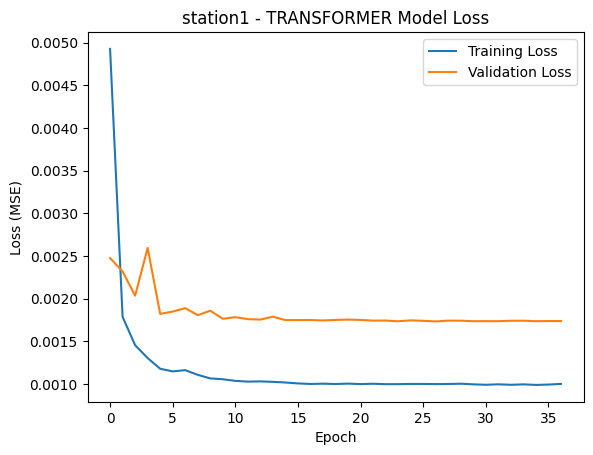


///// Training models for station2 /////

[DEBUG] NaNs in X_train: 0, y_train: 0
[DEBUG] X_train shape: (219225, 24, 6), y_train shape: (219225,)

--- Building and training LSTM model ---
[DEBUG] Model output shape: (None, 1)
INFO: Model will be saved to: C:\Users\John Waugh\Desktop\CS Projects\RunoffForecasting-2.0\models\station2_lstm_model.keras
Epoch 1/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - loss: 0.0821 - val_loss: 0.0027 - learning_rate: 1.0000e-04
Epoch 2/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 0.0036 - val_loss: 0.0026 - learning_rate: 1.0000e-04
Epoch 3/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 0.0022 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 4/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 0.0015 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 5/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 9.8302e-04 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 6/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/ste

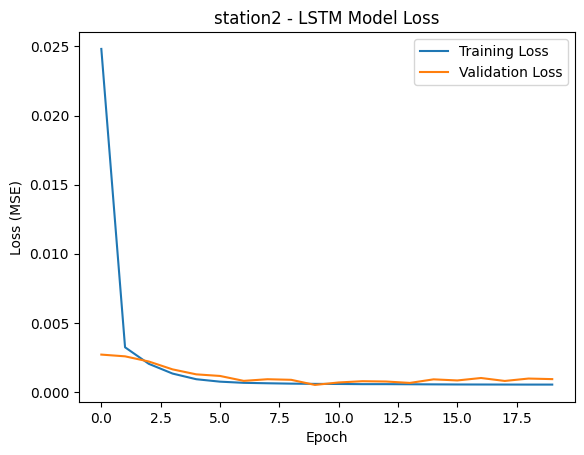


--- Building and training RNN model ---
[DEBUG] Model output shape: (None, 1)
INFO: Model will be saved to: C:\Users\John Waugh\Desktop\CS Projects\RunoffForecasting-2.0\models\station2_rnn_model.keras
Epoch 1/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0376 - val_loss: 0.0024 - learning_rate: 1.0000e-04
Epoch 2/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0049 - val_loss: 0.0039 - learning_rate: 1.0000e-04
Epoch 3/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0029 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 4/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0022 - val_loss: 0.0028 - learning_rate: 1.0000e-04
Epoch 5/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0017 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 6/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0014 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 7/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0011 - val_loss: 8.0369e-04 - 

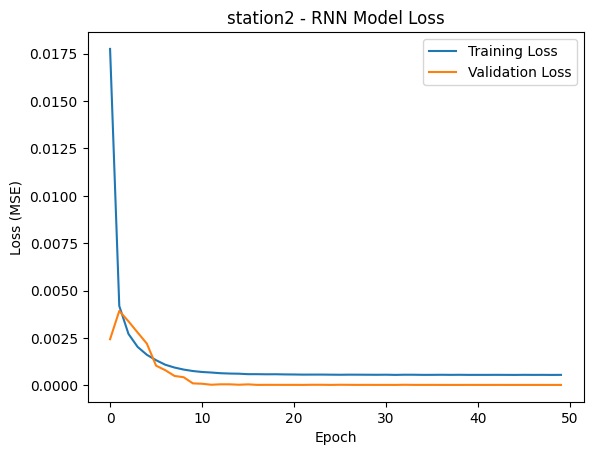


--- Building and training TRANSFORMER model ---
[DEBUG] Model output shape: (None, 1)
INFO: Model will be saved to: C:\Users\John Waugh\Desktop\CS Projects\RunoffForecasting-2.0\models\station2_transformer_model.keras
Epoch 1/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 281s 198ms/step - loss: 0.0412 - val_loss: 5.0534e-04 - learning_rate: 1.0000e-04
Epoch 2/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 270s 197ms/step - loss: 0.0055 - val_loss: 1.3657e-04 - learning_rate: 1.0000e-04
Epoch 3/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 271s 198ms/step - loss: 0.0039 - val_loss: 2.3454e-04 - learning_rate: 1.0000e-04
Epoch 4/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 271s 198ms/step - loss: 0.0031 - val_loss: 4.6536e-04 - learning_rate: 1.0000e-04
Epoch 5/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 272s 198ms/step - loss: 0.0025 - val_loss: 3.3073e-04 - learning_rate: 1.0000e-04
Epoch 6/50
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 272s 198ms/step - loss: 0.0021 - val_loss: 1.0399e-04 - learning_rate: 1.0000e-04
Epoch 7/50
1371/1371 ━━━━━━━━━━━━━━━━

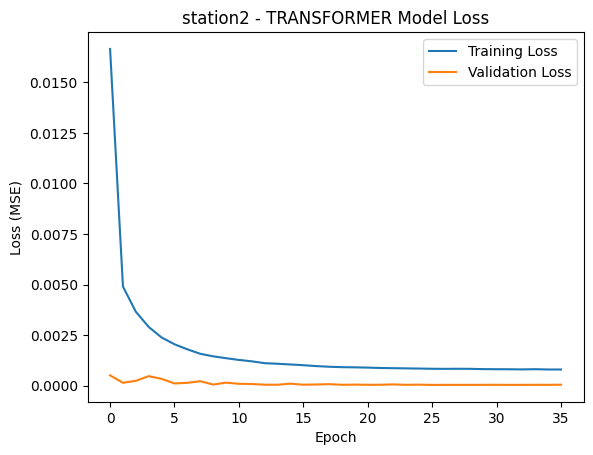



All models have been trained successfully!


In [8]:
EPOCHS = 50 # A shorter number of epochs is fine for this example
BATCH_SIZE = 128
all_histories = {}

for station_name, data in station_data.items():
    print(f"\n{'='*60}")
    print(f"///// Training models for {station_name} /////")
    print(f"{'='*60}\n")
    
    all_histories[station_name] = {}
    
    # DEBUG: Check data for NaNs and shape issues
    X_nan_count = np.isnan(data['X_train']).sum()
    y_nan_count = np.isnan(data['y_train']).sum()
    print(f"[DEBUG] NaNs in X_train: {X_nan_count}, y_train: {y_nan_count}")
    print(f"[DEBUG] X_train shape: {data['X_train'].shape}, y_train shape: {data['y_train'].shape}")
    
    for model_name, builder in model_builders.items():
        print(f"\n--- Building and training {model_name.upper()} model ---")
        
        # Build the model
        model = builder(input_shape)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
            loss='mean_squared_error' # MSE is a good choice for regression
        )
        
        # Show model input/output shape
        print(f"[DEBUG] Model output shape: {model.output_shape}")
        
        # Set model path
        model_path = models_dir / f"{station_name}_{model_name}_model.keras"
        print(f"INFO: Model will be saved to: {model_path.resolve()}") # .resolve() shows the full path
        
        # Define callbacks
        callbacks = [
            keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
        ]
        
        # Train the model
        history = model.fit(
            data['X_train'], data['y_train'],
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2, # Use 20% of training data for validation
            callbacks=callbacks,
            verbose=1
        )
        
        # Log val_loss values
        val_losses = history.history.get('val_loss')
        print(f"[DEBUG] Final val_loss values for {station_name}-{model_name}: {val_losses}")
        
        # Store history and plot loss
        all_histories[station_name][model_name] = history
        
        plt.figure()
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{station_name} - {model_name.upper()} Model Loss')
        plt.ylabel('Loss (MSE)')
        plt.xlabel('Epoch')
        plt.legend()
        plt.savefig(figures_dir / f"{station_name}_{model_name}_loss_plot.png")
        plt.show()

print("\n\nAll models have been trained successfully!")

# Save the histories object for later analysis
with open(models_dir / 'all_training_histories.pkl', 'wb') as f:
    pickle.dump(all_histories, f)
